### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

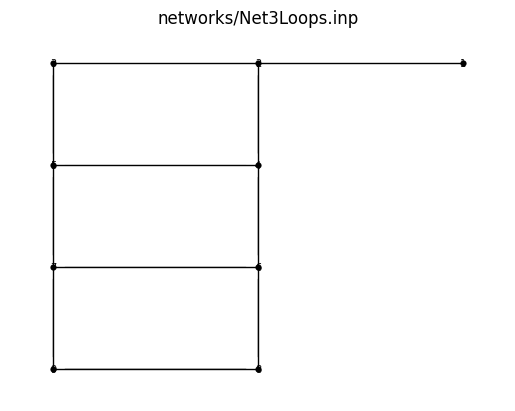

<Axes: title={'center': 'networks/Net3Loops.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/Users/murilo/scratch_dir/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net3Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# print options
# dict(wn.options.hydraulic)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data
epanet_A, epanet_b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

Size of the Jacobian in EPANET simulator: 8
Size of the b vector in EPANET simulator: 8


(name          2          3          4         5         6         7  \
 0     46.928482  19.748489  33.252789  7.703676  13.19863 -2.124948   
 
 name          8          9             1  
 0    -72.548164 -73.077797  4.394531e-07  ,
 name        1         2         3         4         5         6         7  \
 0     0.44441  0.060879  0.355762  0.039486  0.282945  0.120193  0.033109   
 
 name         8         9        10        11  
 0    -0.002405  0.071082  0.062238  0.004422  )

### Define a helper function

Before proceeding to the proper quantum solution of the water network model, let's define a helper function. This function checks that the quantum results are within `TOL`% of those obtained classically. It also fills in lists containing the final values of pressures and flow rates obtained.

In [6]:
TOL = 5  # => per cent
DELTA = 1.0e-12

classical_res = []
quantum_res = []


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    def calculate_differences(classical_value, quantum_value):
        """Helper function to evaluate percentage difference between classical and quantum results."""
        is_close_to_classical = abs(classical_value - quantum_value) / abs(classical_value + DELTA) <= TOL / 100.0
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {TOL}% of classical result {classical_value}")
            quantum_res.append(quantum_value)
            classical_res.append(classical_value)
        return is_close_to_classical
    
    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert calculate_differences(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message= f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert calculate_differences(classical_value, quantum_value), message

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [5]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_vqls = sim.run_sim(linear_solver=linear_solver)

compare_results(results_epanet, results_vqls)

results_vqls.node["pressure"], results_vqls.link["flowrate"]

VQLS Iteration 1000 Cost 7.166e-03
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 7.165705E-03    MAXCV = 0.000000E+00
   X =-2.764520E-01   1.353739E-01   1.106040E+00   1.714540E+00  -5.528472E-01
       3.371128E-01   2.567670E+00   2.404768E+00  -9.545733E-02   5.489980E-02
       2.415995E+00   7.365931E-01
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 76
         Function evaluations: 1716
         Gradient evaluations: 132
HEREEE <class 'scipy.sparse._csc.csc_matrix'>
VQLS Iteration 1000 Cost 6.139e-03
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 6.139048E-03    MAXCV = 0.000000E+00
   X =-3.096739E-01   2.164609E+00  -1.433605E+00   8.334888E-01   3.576160E+00
       3.036274E+00  -1.066797E+00  -4.289338E+00   4.315791E-01   1.444831E+00
      -7.695644E-01   9.257240E-01
Optimization terminated successfully.
       

(name          2          3          4         5          6         7  \
 0     46.936539  19.764673  33.266758  7.738372  13.219615 -2.087871   
 
 name          8          9             1  
 0    -72.413597 -72.942719  4.394531e-07  ,
 name         1         2         3         4         5         6         7  \
 0     0.444262  0.060863  0.355631  0.039472  0.282838  0.120142  0.033094   
 
 name         8         9        10        11  
 0    -0.002423  0.071034  0.062192  0.004419  )

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

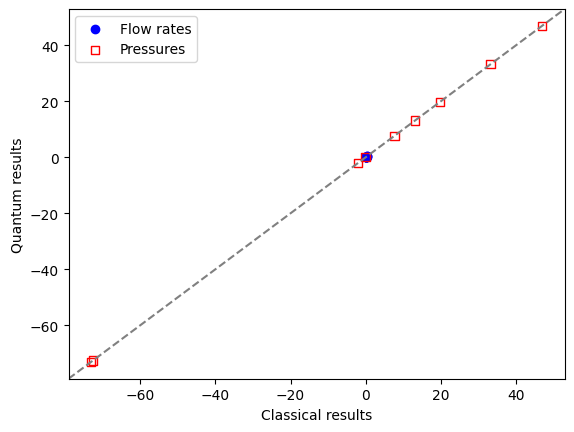

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(classical_res[:n_pipes], quantum_res[:n_pipes], label="Flow rates", color="blue", marker="o")
plt.scatter(classical_res[n_pipes:], quantum_res[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()